In [3]:
import pandas as pd 
import plotly.express as px
import pandas as pd 
from darts import TimeSeries
import logging
from darts.metrics import mae, mse
from datetime import datetime
import pytz
from darts.models import Prophet,LightGBMModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import pandas as pd
from darts.timeseries import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics.metrics import mse
from darts.dataprocessing.transformers import Scaler
import os
from data_aggregation_engine import fetch_CO2_data, fetch_day_ahead_prices
import matplotlib.pyplot as plt 
import scienceplots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

plt.style.use('science')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = pd.read_csv('../data/sym_data/inflow_and_weather_data.csv')


In [5]:
start_date="2023-02-01" 
end_date="2023-04-20"

data = data[(data['time'] >= start_date) & (data['time'] <= end_date)]


In [6]:
data["time"] = pd.to_datetime(data["time"])

In [7]:
data = data.set_index("time")
data["inflow"] = data["inflow"].ewm(alpha=0.3).mean()

In [8]:
def to_darts_timeseries(data: pd.DataFrame, training_cutoff,  filling_nan = True, train_test_split = True, scale=False):
    series = TimeSeries.from_dataframe(data, freq="1H")
    ts_series = fill_missing_values(series)
    
    if filling_nan and train_test_split and scale:
        print("scaling")
        transformer = Scaler()
        ts_series = transformer.fit_transform(ts_series)
        train_df, test_df = ts_series.split_after(training_cutoff)
        return transformer, ts_series, train_df, test_df
    
    elif filling_nan and train_test_split and not scale:
        train_df, test_df = ts_series.split_after(training_cutoff)
        return ts_series, train_df, test_df
    
    elif filling_nan and not train_test_split and not scale:
        ts_series = fill_missing_values(series)
        return ts_series

In [9]:
training_cutoff = pd.Timestamp("20230210")
ts_series, train_df, test_df = to_darts_timeseries(data, training_cutoff,  train_test_split=True, scale=False)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/home/alqua/anaconda3/envs/torch_env/lib/python3.11/site-packages/darts/timeseries.py:4736: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [10]:
def generate_covariates(ts_series):
    year_covariates   = datetime_attribute_timeseries(ts_series, attribute="year", one_hot=False)
    month_covariates  = datetime_attribute_timeseries(ts_series, attribute="month", one_hot=False)
    day_covariates    = datetime_attribute_timeseries(ts_series, attribute="day", one_hot=False)
    hour_covariates   = datetime_attribute_timeseries(ts_series, attribute="hour", one_hot=False)
    precip_covariates = ts_series["precip_past1min"]
    wind_covariates   = ts_series["wind_speed"]
    humidity_covariates = ts_series["humidity"]

    future_cov =  precip_covariates.stack(wind_covariates).stack(year_covariates).stack(month_covariates).stack(day_covariates).stack(hour_covariates)

    return future_cov


In [11]:
prophet_model = Prophet()

In [12]:
#generate chunks
chunks = [test_df.pd_dataframe()[i:i + 24] for i in range(0, test_df.pd_dataframe().shape[0], 24)]

In [13]:
fh = 24
results_df = pd.DataFrame()
predictions_series_lower_q = pd.Series()
predictions_series_median_q = pd.Series()
predictions_series_upper_q = pd.Series()

for chunk in chunks:
    #generate past covariates on the past dataset 
    past_cov_dataframe = generate_covariates(train_df)
    prophet_model.fit(train_df["inflow"], future_covariates=past_cov_dataframe) 

    #generate timeseries object from forecasts dataframe
    future_dataframe = TimeSeries.from_dataframe(chunk, freq="1H")
    results_df = pd.concat([results_df, chunk])
    #extract the future inflow (not included in the model)
    unobserved_inflow = future_dataframe["inflow"]
    #generate future covariates on new observation
    future_cov_dataframe = generate_covariates(future_dataframe)
    future_cov_dataframe = past_cov_dataframe.concatenate(future_cov_dataframe) 
    #predict the next 24 hours
    prophet_predictions = prophet_model.predict(fh, future_covariates=future_cov_dataframe,  num_samples=200)

    predictions_series_lower_q = pd.concat([predictions_series_lower_q, prophet_predictions.quantile_df(0.1)["inflow_0.1"]], axis=0)
    predictions_series_median_q = pd.concat([predictions_series_median_q, prophet_predictions.quantile_df(0.5)["inflow_0.5"]], axis=0)
    predictions_series_upper_q = pd.concat([predictions_series_upper_q, prophet_predictions.quantile_df(0.9)["inflow_0.9"]], axis=0)

    #evaluate the prediction with the mae 
    #print(mae(prophet_predictions.quantile_timeseries(0.05), unobserved_inflow))
    #concatenate the old observation with the new data to enable new predictions
    train_df = train_df.concatenate(future_dataframe)

16:09:24 - cmdstanpy - INFO - Chain [1] start processing
16:09:24 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_15539/3429302598.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions_series_lower_q = pd.concat([predictions_series_lower_q, prophet_predictions.quantile_df(0.1)["inflow_0.1"]], axis=0)
/tmp/ipykernel_15539/3429302598.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions_series_median_q = pd.concat([predictions_series_median_q, prophet_predictions.quantile_df(0.5)["inflow_0.5"]], axis=0)
/tmp/ipykernel_15

In [14]:
results_df["inflow_0.1"] = predictions_series_lower_q
results_df["inflow_0.5"] = predictions_series_median_q
results_df["inflow_0.9"] = predictions_series_upper_q

In [ ]:
import pandas as pd 
import datetime as dt
from entsoe import EntsoePandasClient
import requests
import pandas as pd


start_date = "2023-02-10"
end_date = "2023-03-02"
price_area = "DK2"
country_code = 'DK_2'


co2_data = fetch_CO2_data(start_date, end_date, price_area, resample=True)
day_ahead_prices = fetch_day_ahead_prices(start_date, end_date, country_code)

In [32]:
results_df.index = results_df.index.tz_localize ('UTC')
day_ahead_prices.index = day_ahead_prices.index.tz_convert('UTC')
results_df = results_df.join(co2_data).join(day_ahead_prices)


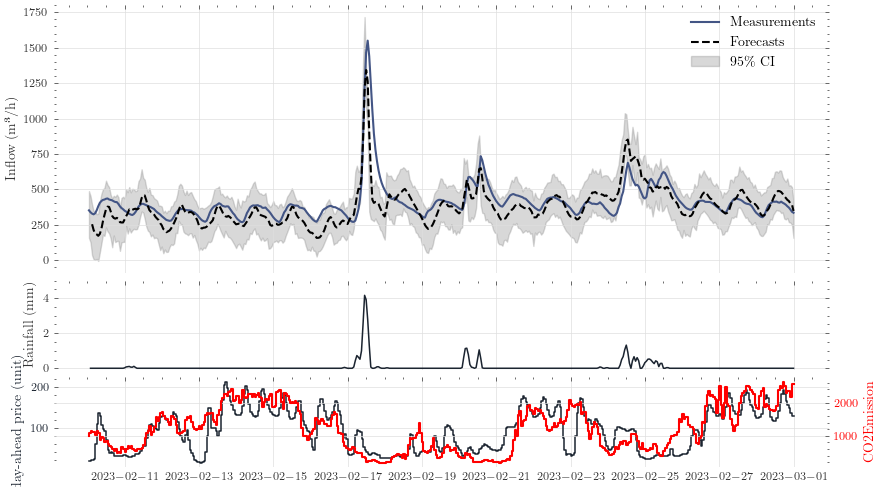

In [35]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0.05)

# Main Time Series Plot
ax1 = fig.add_subplot(gs[0])
ax1.plot(results_df.index, results_df["inflow"], color="#435585", linewidth=1.5, label="Measurements")
ax1.plot(results_df.index, results_df["inflow_0.5"].rolling(3).mean(), linestyle="dashed", color="black", linewidth=1.5, label="Forecasts")
ax1.fill_between(results_df.index, results_df["inflow_0.1"], results_df["inflow_0.9"], color='gray', alpha=0.3, label=r'95\% CI')
ax1.set_ylabel('Inflow (m³/h)')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax1.legend()

# First Regressor Data Plot (Rainfall)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(results_df["precip_past1min"].index, results_df["precip_past1min"].rolling(2).mean(), linewidth=1.1, color = "#1B2430")
ax2.set_ylim((-0.1,5))
ax2.set_ylabel('Rainfall (mm)')

# Additional Regressor Data Plot (Duplicate of Rainfall plot)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax3.step(results_df["price"].index, results_df["price"].rolling(2).mean(), linewidth=1.1, color = "#1B2430")
ax3.set_ylabel('day-ahead price (unit)', color="#1B2430")
ax3.tick_params(axis='y', labelcolor="#1B2430")

ax3_2 = ax3.twinx()
ax3_2.step(results_df["CO2Emission"].index, results_df["CO2Emission"], color='red', linewidth=1.5, linestyle='-',  label='Delta')
ax3_2.set_ylabel('CO2Emission', color='red')
ax3_2.tick_params(axis='y', labelcolor='red')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

#plt.savefig("prophet_forecast_results.pdf", format='pdf', dpi=300)
plt.show()

In [60]:
#results_df.to_parquet('aggregated_data_for_mpc.par')
